# Generate a circuit

> A minimal example to generate a circuit. We load a pre-trained (SRV, 3 to 8 qubit) model and condition on a given Schmidt-Rank-Vector (SRV).

In [ ]:
from genQC.imports import *
import genQC.utils.misc_utils as util

from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer
from genQC.platform.simulation import Simulator, CircuitBackendType

from genQC.inference.sampling import generate_tensors, decode_tensors_to_backend
from genQC.inference.evaluation_helper import get_srvs

In [ ]:
util.MemoryCleaner.purge_mem()      # clean existing memory alloc
device = util.infer_torch_device()  # use cuda if we can
device

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


device(type='cuda')

In [ ]:
# We set a seed to pytorch, numpy and python. 
# Note: This will also set deterministic algorithms, possibly at the cost of reduced performance!
util.set_seed(0)

## Setup and load

Load the pre-trained model directly from [Hugging Face: Floki00/qc_srv_3to8qubit](https://huggingface.co/Floki00/qc_srv_3to8qubit).

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("Floki00/qc_srv_3to8qubit", device)

Check on what gates the model was trained

In [ ]:
pipeline.gate_pool

['h', 'cx']

Set 20 sample steps and use rescaled guidance-formula.

In [ ]:
pipeline.guidance_sample_mode = "rescaled"
pipeline.scheduler.set_timesteps(20) 

## Inference / sampling

Set our desired condition SRV

In [ ]:
srv           = [2, 1, 2, 1, 2]  # set your target SRV; can be 3 to 8 qubit
num_of_qubits = len(srv)          

prompt = f"Generate SRV: {srv}"  # model was trained with this phrase
prompt

'Generate SRV: [2, 1, 2, 1, 2]'

Define sample parameters

In [ ]:
g         = 10      # guidance scale
max_gates = 16      # how many time steps the tensor encoding has
samples   = 64      # how many circuits to generate

Sample tokenized circuits

In [ ]:
out_tensor = generate_tensors(pipeline, prompt, samples, num_of_qubits, num_of_qubits, max_gates, g, no_bar=False)

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 64 tensors


Check how many distinct tensors we got:

In [ ]:
out_tensor.unique(dim=0).shape[0]

64

Let's look what is generated. Note, 3 is the padding token (or empty action).

In [ ]:
out_tensor[:2]

tensor([[[ 1,  0,  2, -2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  1, -2,  0, -2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  2,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]],

        [[ 0,  0,  0,  2,  1, -2,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 2,  1, -2, -2,  0,  2,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [-2,  0,  2,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3]]], device='cuda:0')

## Convert to qiskit circuit 

To get a qiskit circuit we need to do: 

- apply cosine similarity to go from embeddings to token matrices (the function `generate_tensors` did this already)
- parse token matrix to qiskit and filter out error circuits
- calculate SRV and plot circuits

In [ ]:
vocabulary = {g:i+1 for i, g in enumerate(pipeline.gate_pool)} 
tokenizer  = CircuitTokenizer(vocabulary)
simulator  = Simulator(CircuitBackendType.QISKIT)

In [ ]:
qc_list, error_cnt = decode_tensors_to_backend(simulator, tokenizer, out_tensor)
qc_list[0].__class__

qiskit.circuit.quantumcircuit.QuantumCircuit

Generated error circuits (token matrices that don't correspond to circuits):

In [ ]:
error_cnt

0

What SRVs did we get:

In [ ]:
srv_list = get_srvs(simulator, qc_list)
srv_list[:4]

[[2, 1, 2, 1, 2], [2, 1, 2, 1, 2], [2, 1, 2, 1, 2], [2, 1, 2, 1, 2]]

That is an accuracy of:

In [ ]:
sum(srv==x for x in srv_list)/len(srv_list)

0.96875

Finally plot some of the circuits:

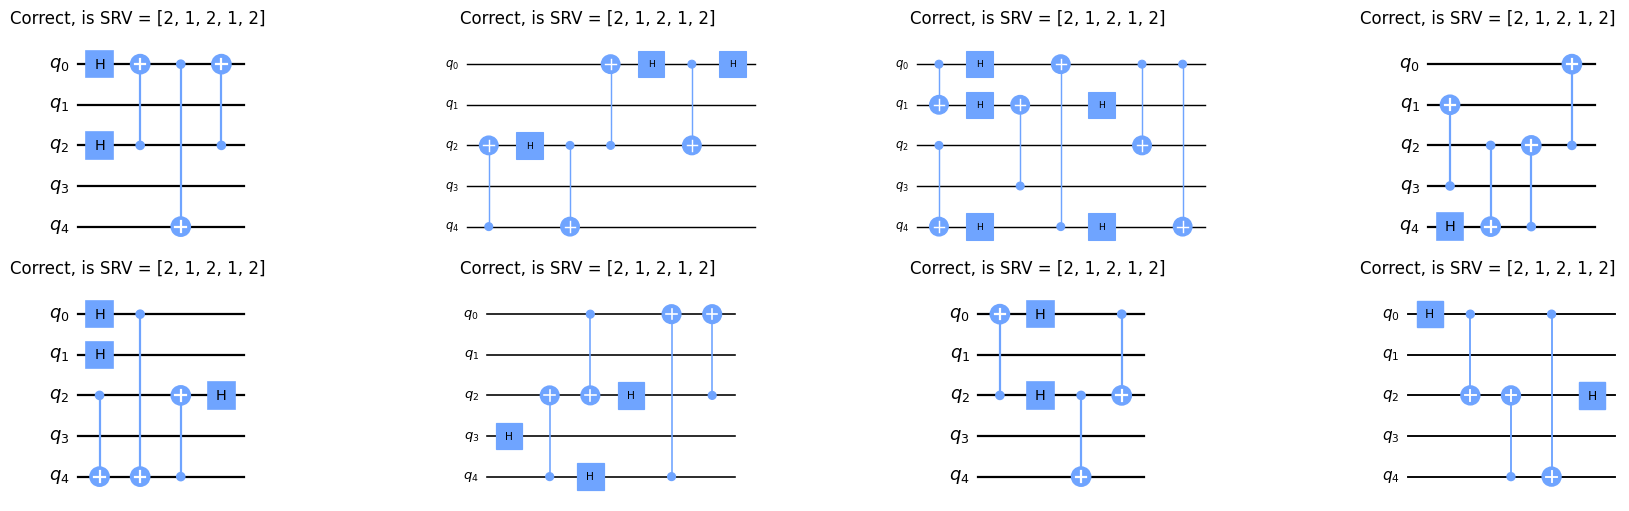

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(18,5), constrained_layout=True)
for qc,is_srv,ax in zip(qc_list, srv_list, axs.flatten()): 
    is_srv = [int(x) for x in is_srv]
    qc.draw("mpl", plot_barriers=False, ax=ax, style = "clifford")
    ax.set_title(f"{'Correct' if is_srv==srv else 'NOT correct'}, is SRV = {is_srv}")
plt.show()

In [ ]:
import genQC
print("genQC Version", genQC.__version__)

genQC Version 0.2.0
